In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet
from chronos import ChronosPipeline
from torch import bfloat16, tensor

from sklearn.manifold import TSNE

In [2]:
with sqlite3.connect('./data/data.db') as con:
    n_rows = pd.read_sql('select count(*) from train_data;', con=con).iloc[0, 0]
    df = pd.read_sql(f'select ts from train_data order by ts asc limit 1 offset {round(0.8*n_rows)};', con=con)

df

,ts
0,2022-05-03 17:18:26


In [81]:
with sqlite3.connect('./data/data.db') as con:
    train_df = pd.read_sql("select * from train_data where ts <= '2022-05-03 17:18:26'", con=con, parse_dates=['ts'])
    test_df = pd.read_sql("select * from train_data where ts > '2022-05-03 17:18:26'", con=con, parse_dates=['ts'])

print(train_df.shape, test_df.shape)

(8618871, 23) (2154717, 23)


## STL Decomposition

In [45]:
# Failure 1 
col = 'tp3'

with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, failure_id, {col} 
        from train_data 
        where 
            '2022-02-25 00:00:00' <= ts and ts < '2022-03-02 00:00:00'
        order by ts asc
    """.format(col=col), con=con, parse_dates=['ts'])

print(df.shape)

(360005, 3)


In [46]:
df[df.ts == '2022-02-28 21:53:00']

,ts,failure_id,tp3
280384,2022-02-28 21:53:00,1.0,8.874


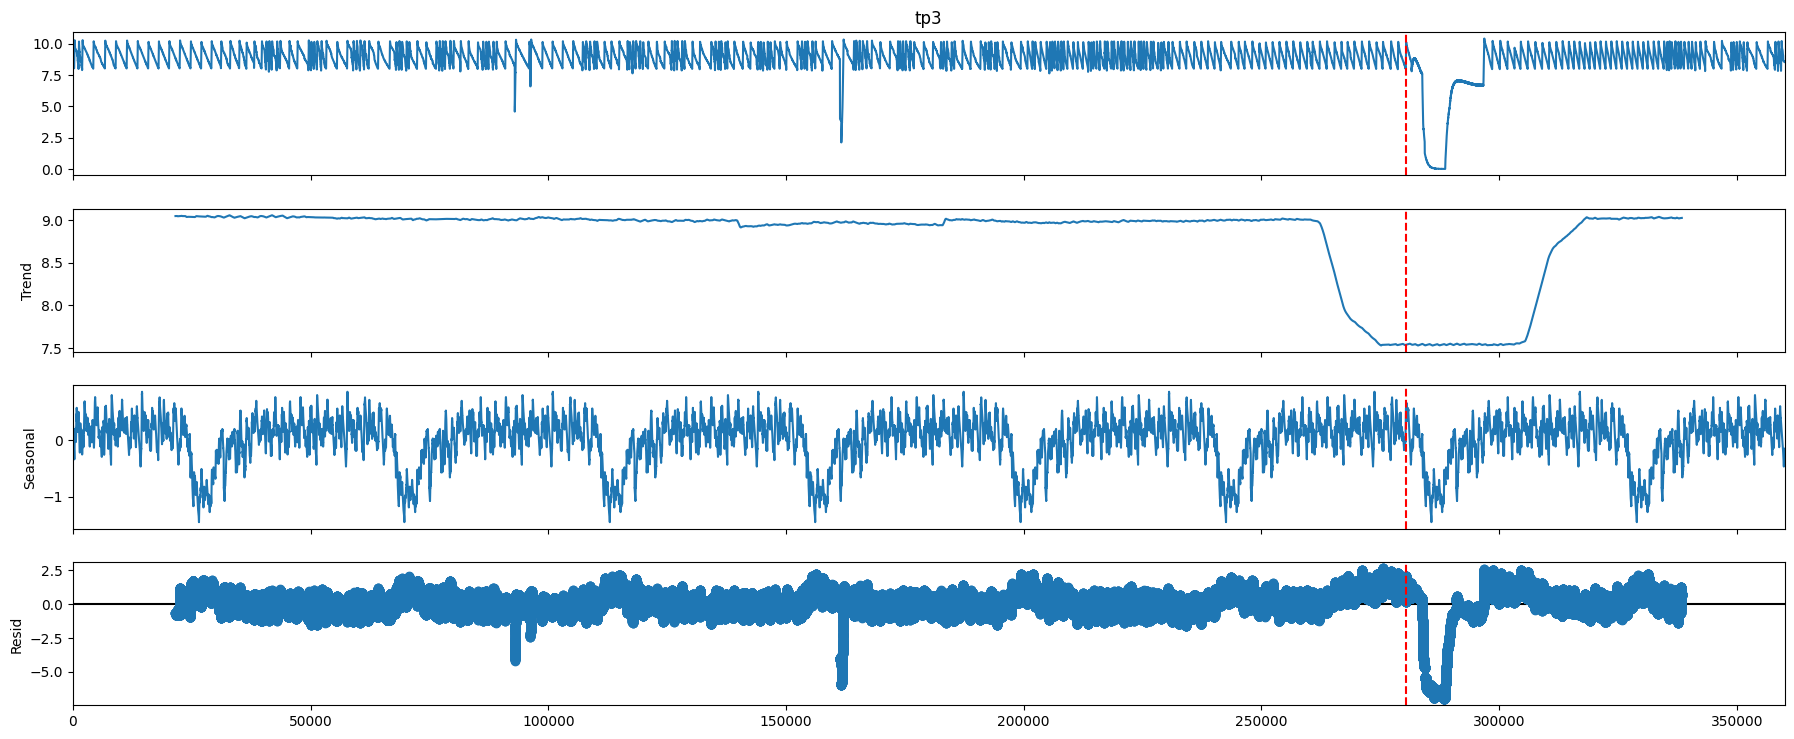

In [47]:
decomposed = seasonal_decompose(df[col], model='additive', period=30*24*60)

fig = decomposed.plot();
fig.set_size_inches(20, 8);

axes = fig.get_axes()
for ax in axes:
    ax.axvline(x=280384, color='r', linestyle='--', label='Anomaly');

## Isolation Forest

In [4]:
clf = IsolationForest()
clf.fit(train_df.drop(columns=['ts', 'failure_id']).head(10000))
test_df['y_pred_is'] = clf.predict(test_df.drop(columns=['ts', 'failure_id']))

## Local Outlier Factor

In [ ]:
lof = LocalOutlierFactor()
test_df['y_pred_lof'] = lof.fit_predict(test_df.drop(columns=['ts', 'failure_id']))

## Facebook Prophet

In [6]:
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, lps, oil_temperature
        from train_data 
        where 
            '2022-01-06 06:00:00' <= ts and ts < '2022-01-10 08:00:00'
        order by ts asc
    """, con=con, parse_dates=['ts'])

print(df.shape)

(295204, 3)


In [56]:
model = Prophet(
    # seasonality_prior_scale=100., 
    changepoint_prior_scale=0.5,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.add_seasonality(name='30min', period=60*30, fourier_order=5)
model.add_seasonality(name='daily', period=72001, fourier_order=5)

model.fit(df.query("ts <= '2022-01-10 05:00:00'").rename(columns={'ts': 'ds', 'oil_temperature': 'y'}))

19:11:40 - cmdstanpy - INFO - Chain [1] start processing
19:13:32 - cmdstanpy - INFO - Chain [1] done processing


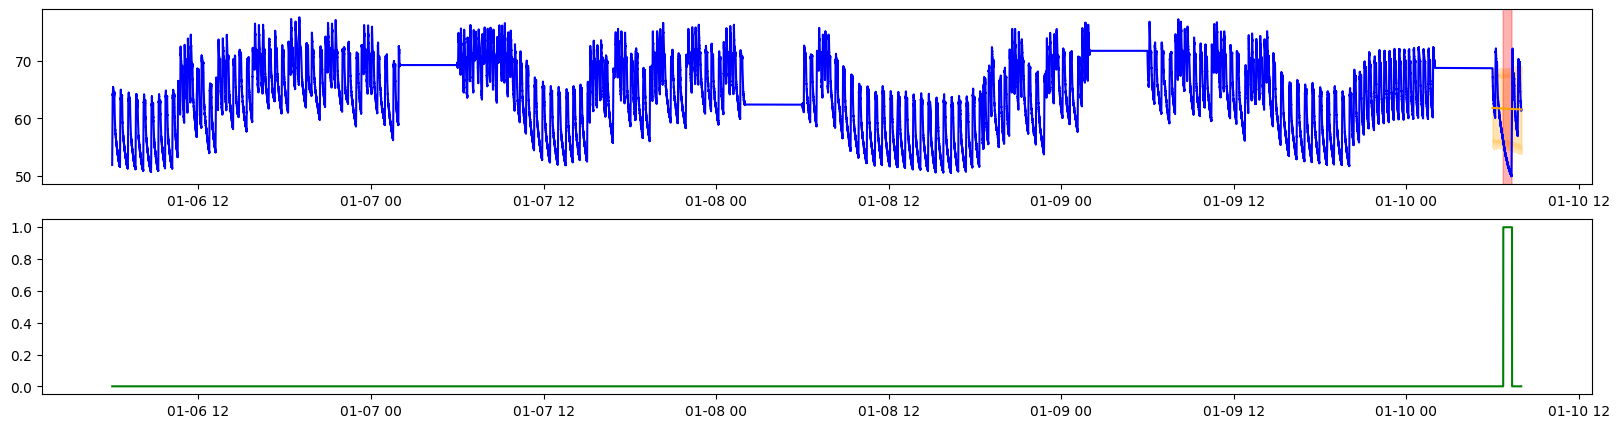

In [57]:
future = pd.DataFrame(pd.date_range(start='2022-01-10 06:00:00', end='2022-01-10 08:00:00', freq='s'), columns=['ds'])
forecast = model.predict(future)

fig, ax = plt.subplots(2, 1, figsize=(20, 5))

ax[0].plot(df['ts'], df['oil_temperature'], label='Observed', color='blue')
ax[0].plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
ax[0].fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'], color='orange', alpha=0.3, label='Forecast Interval')

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)

ax[0].fill_between(df['ts'], ymax*2, 0, where=(df['lps'] == 1), color='red', alpha=0.3, label='Anomaly Period')

ax[1].plot(df['ts'], df['lps'], label='LPS', color='green')

plt.show()

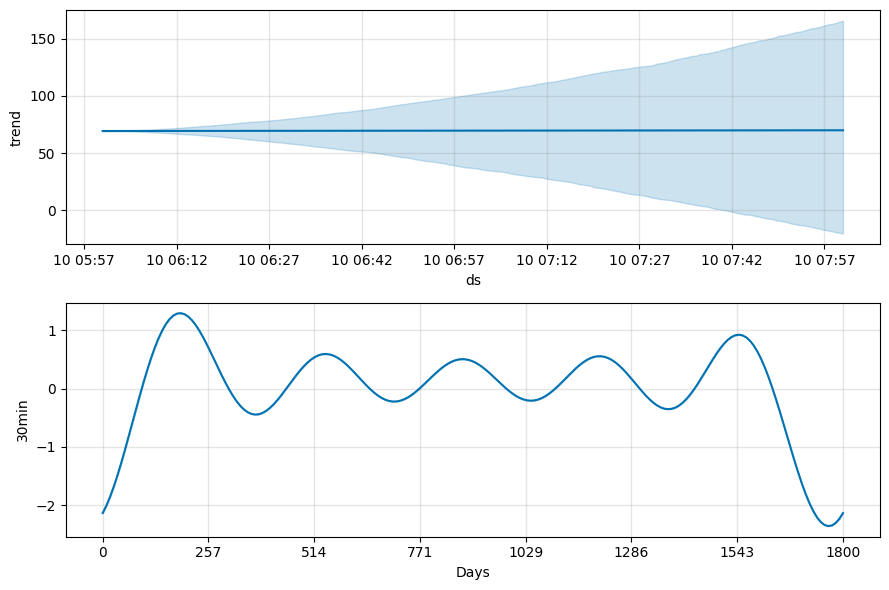

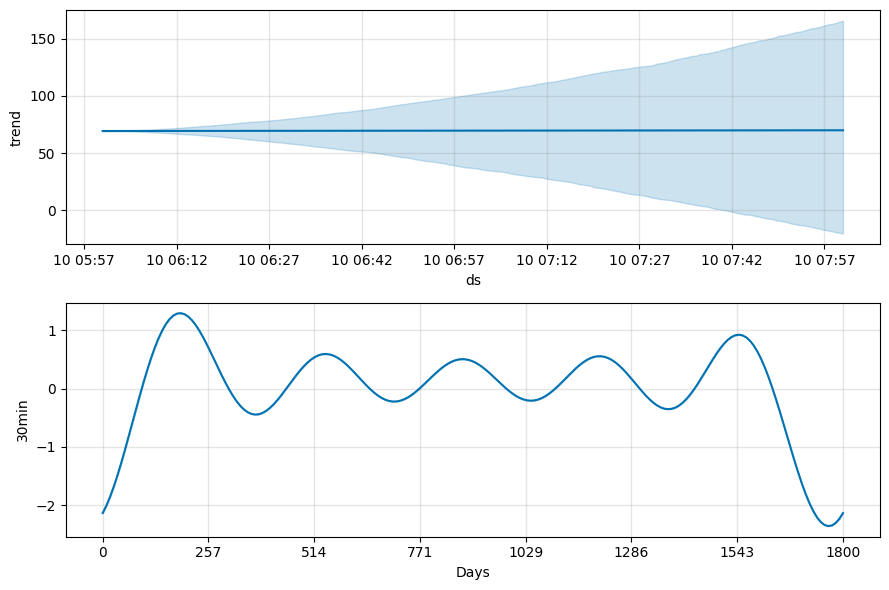

In [39]:
model.plot_components(forecast)

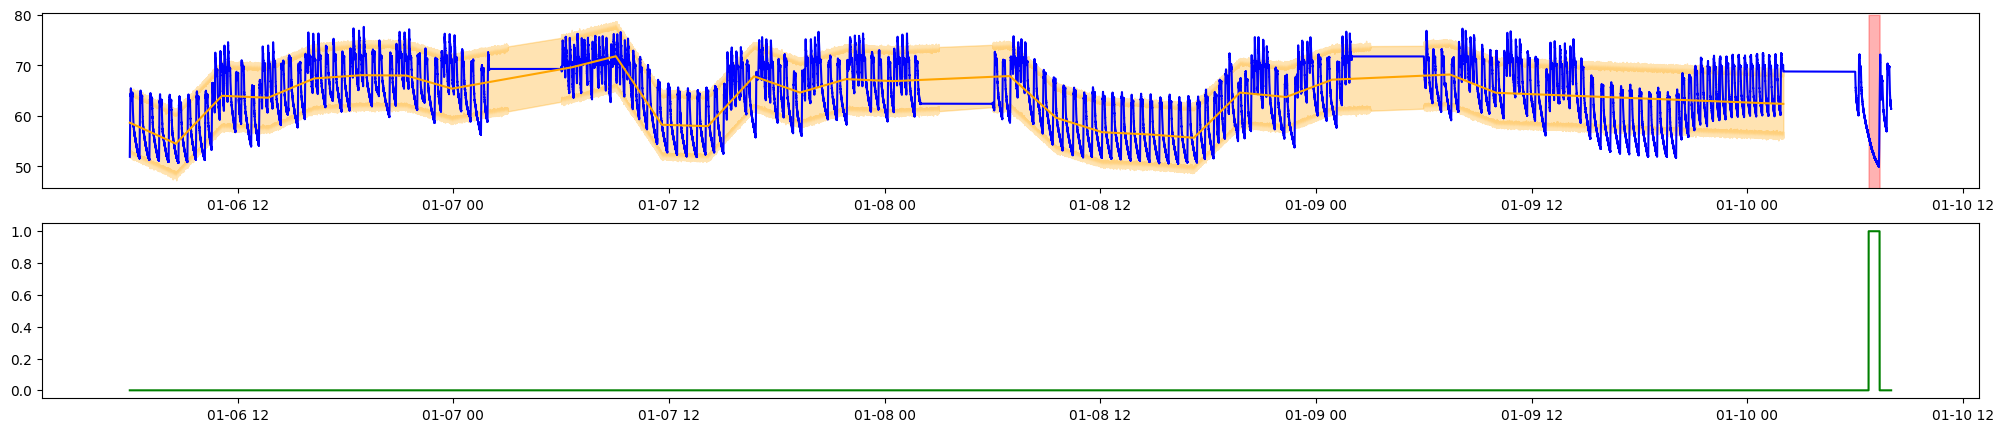

In [60]:
future = pd.DataFrame(pd.date_range(start='2022-01-06 06:00:00', end='2022-01-10 02:00:00', freq='s'), columns=['ds'])
future.query("(6 <= ds.dt.hour) & (ds.dt.hour <= 23) | (0 <= ds.dt.hour) & (ds.dt.hour <= 2)", inplace=True)
forecast = model.predict(future)

fig, ax = plt.subplots(2, 1, figsize=(25, 5))

ax[0].plot(df['ts'], df['oil_temperature'], label='Observed', color='blue')
ax[0].plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
ax[0].fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'], color='orange', alpha=0.3, label='Forecast Interval')

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)

ax[0].fill_between(df['ts'], 80, 0, where=(df['lps'] == 1), color='red', alpha=0.3, label='Anomaly Period')

ax[1].plot(df['ts'], df['lps'], label='LPS', color='green')

plt.show()

In [7]:
model = Prophet(
    changepoint_prior_scale=0.5,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.add_seasonality(name='30min', period=60*30, fourier_order=5)
model.add_seasonality(name='daily', period=72001, fourier_order=5)

model.fit(df.query("ts <= '2022-01-09 02:00:01'").rename(columns={'ts': 'ds', 'oil_temperature': 'y'}))

18:44:04 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing


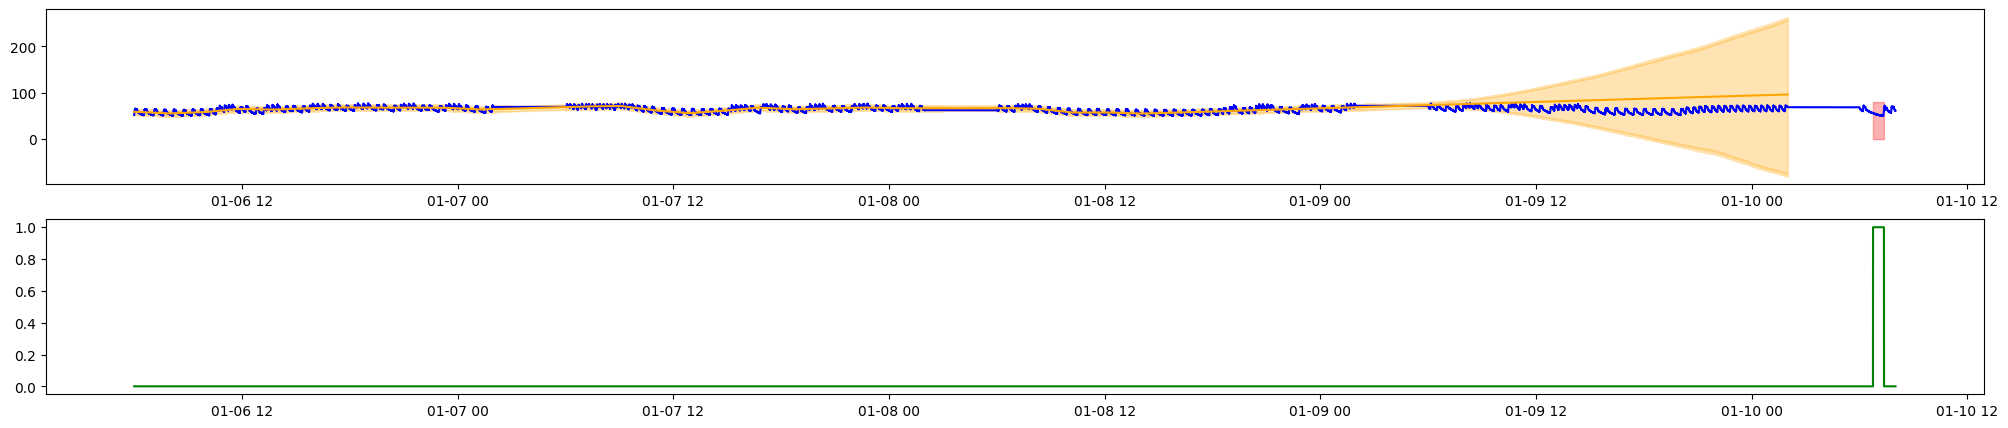

In [8]:
future = pd.DataFrame(pd.date_range(start='2022-01-06 06:00:00', end='2022-01-10 02:00:00', freq='s'), columns=['ds'])
future.query("(6 <= ds.dt.hour) & (ds.dt.hour <= 23) | (0 <= ds.dt.hour) & (ds.dt.hour <= 2)", inplace=True)
forecast = model.predict(future)

fig, ax = plt.subplots(2, 1, figsize=(25, 5))

ax[0].plot(df['ts'], df['oil_temperature'], label='Observed', color='blue')
ax[0].plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
ax[0].fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'], color='orange', alpha=0.3, label='Forecast Interval')

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)

ax[0].fill_between(df['ts'], 80, 0, where=(df['lps'] == 1), color='red', alpha=0.3, label='Anomaly Period')

ax[1].plot(df['ts'], df['lps'], label='LPS', color='green')

plt.show()

## Amazon Chronos

In [6]:
with sqlite3.connect('./data/data.db') as con:
    df = pd.read_sql("""
        select ts, lps, oil_temperature
        from train_data 
        where 
            '2022-01-06 06:00:00' <= ts and ts < '2022-01-10 08:00:00'
        order by ts asc
    """, con=con, parse_dates=['ts'])

print(df.shape)

(295204, 3)


In [9]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map = "auto",
    dtype = bfloat16
)

In [10]:
df.query("ts > '2022-01-10 05:00:00'").shape[0]

7200

In [11]:
quantiles, mean = pipeline.predict_quantiles(
    context=tensor(df["oil_temperature"]),
    prediction_length=df.query("ts > '2022-01-10 05:00:00'").shape[0],
    quantile_levels=[0.1, 0.5, 0.9],
)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


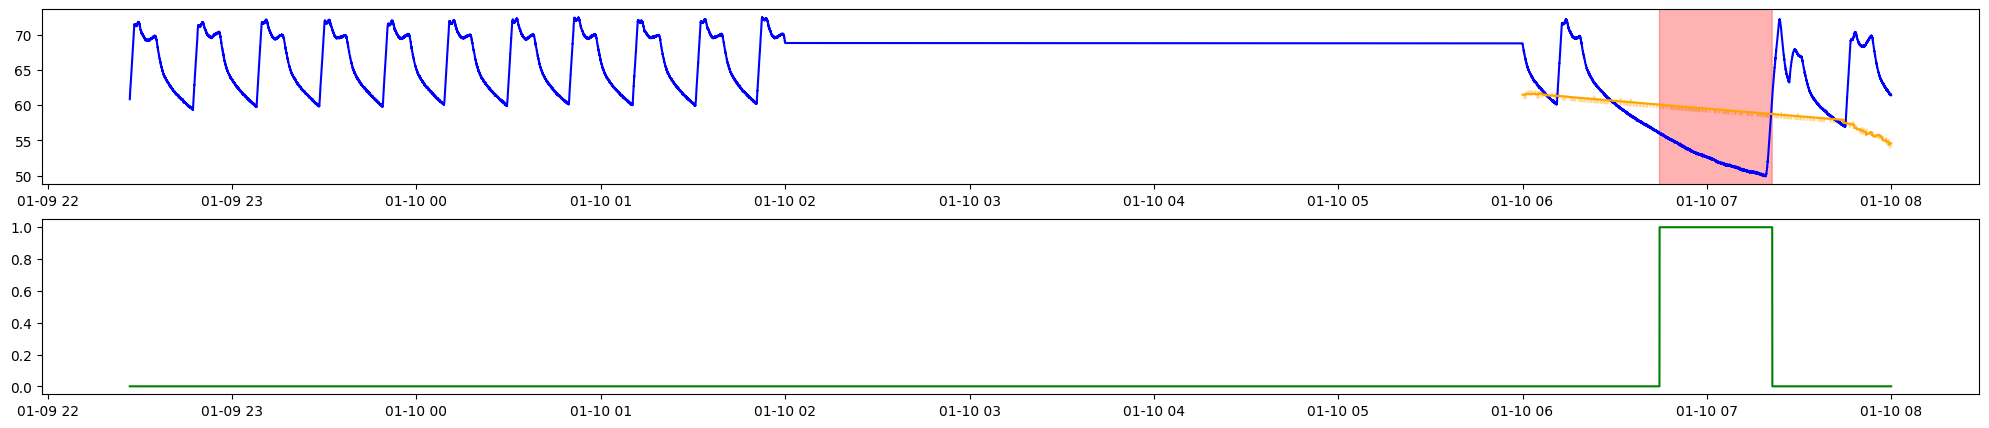

In [18]:
chronos_forecast = pd.DataFrame()
chronos_forecast['ts'] = df.query("ts > '2022-01-10 05:00:00'").ts
chronos_forecast['low'] = low.numpy()
chronos_forecast['median'] = median.numpy()
chronos_forecast['high'] = high.numpy()

fig, ax = plt.subplots(2, 1, figsize=(25, 5))

n = 20000
ax[0].plot(df['ts'].tail(n), df['oil_temperature'].tail(n), label='Observed', color='blue')
ax[0].plot(chronos_forecast['ts'], chronos_forecast['median'], label='Chronos Forecast', color='orange')
ax[0].fill_between(chronos_forecast['ts'], chronos_forecast['high'], chronos_forecast['low'], color='orange', alpha=0.3, label='Chronos Forecast Interval')

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin, ymax)

ax[0].fill_between(df['ts'], 80, 0, where=(df['lps'] == 1), color='red', alpha=0.3, label='Anomaly Period')

ax[1].plot(df['ts'].tail(n), df['lps'].tail(n), label='LPS', color='green')

plt.show()

## pyOD

In [9]:
!pip install pyod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.8 MB/s  0:00:00 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 14.8 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 49.6 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pyod]3/4 [pyod]]te]
